In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from pprint import pprint
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]

# Import Previous Files

In [34]:
# Import all previous files
# open pickle
train_df_dict = pd.read_pickle('data/train_df_dict.pkl')
train_df_dict_L = pd.read_pickle('data/train_df_dict_L.pkl')
test_df_dict = pd.read_pickle('data/test_df_dict.pkl')

lookback = 6

# import resale_flat_transactions_clean
resale_flat_transactions_clean = pd.read_csv('data/resale_flat_transactions_clean.csv')

# import features 
all_district_var_ts = pd.read_pickle('data/all_district_var_ts.pkl')
all_district_var_ts_LI = pd.read_pickle('data/all_district_var_ts_LI.pkl')

# replace NaN values with 0 since we are using LSTM
# Mask layer will mask the 0 values
# merge the train set with the features
train_lstm_df_dict = {}
for district_no, district_df in train_df_dict.items():
    train_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    train_lstm_df_dict[district_no] = train_lstm_df_dict[district_no].fillna(0)

train_lstm_df_dict_L = {}
for district_no, district_df in train_df_dict_L.items():
    train_lstm_df_dict_L[district_no] = district_df.to_frame().merge(all_district_var_ts_LI[district_no], left_index=True, right_index=True, how='left')

# merge the test set with the features
test_lstm_df_dict = {}
for district_no, district_df in test_df_dict.items():
    test_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    test_lstm_df_dict[district_no] = test_lstm_df_dict[district_no].fillna(0)


# Normalize the data for training

In [35]:
# Normalize the data
# create scalers for each district
scaler_dict = {}
for district_no, district_df in train_lstm_df_dict.items():
    scaler_dict[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict[district_no].fit(district_df)

# create scalers for each district
scaler_dict_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    scaler_dict_L[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict_L[district_no].fit(district_df)

# transform the train set
train_lstm_df_dict_scaled = {}
for district_no, district_df in train_lstm_df_dict.items():
    train_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the train set
train_lstm_df_dict_scaled_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    train_lstm_df_dict_scaled_L[district_no] = pd.DataFrame(
        scaler_dict_L[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the test set
test_lstm_df_dict_scaled = {}
for district_no, district_df in test_lstm_df_dict.items():
    test_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# Format Data for LSTM

In [36]:
# convert all data 

lookback = 6
num_features = len(train_lstm_df_dict_scaled[1].columns)

# create dataset for each district
train_lstm_dataset_dict = {}
for district_no, district_df in train_lstm_df_dict_scaled.items():
    train_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
train_lstm_dataset_dict_L = {}
for district_no, district_df in train_lstm_df_dict_scaled_L.items():
    train_lstm_dataset_dict_L[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
test_lstm_dataset_dict = {}
for district_no, district_df in test_lstm_df_dict_scaled.items():
    test_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)


In [37]:
# check generator dimensions
for i in range(len(test_lstm_dataset_dict[1])):
    x, y = test_lstm_dataset_dict[1][i]
    print(x.shape, y.shape)
print(len(test_lstm_dataset_dict[1]))

len(test_lstm_df_dict_scaled[1])

(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
(1, 6, 10) (1, 10)
18


24

# LSTM Model on district 1

In [38]:
def fit_lstm(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model



model_1 = fit_lstm(train_lstm_dataset_dict[1])


Epoch 1/20


2023-04-05 21:46:16.575882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:46:18.265348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:46:19.116888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:46:20.373452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:46:21.636509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:46:22.581876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:46:23.405906: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 33s 547ms/step - loss: 0.1902
Epoch 2/20
33/33 [==============================] - 9s 269ms/step - loss: 0.1705
Epoch 3/20
33/33 [==============================] - 8s 251ms/step - loss: 0.1558
Epoch 4/20
33/33 [==============================] - 9s 264ms/step - loss: 0.1533
Epoch 5/20
33/33 [==============================] - 8s 235ms/step - loss: 0.1554
Epoch 6/20
33/33 [==============================] - 8s 245ms/step - loss: 0.1539
Epoch 7/20
33/33 [==============================] - 8s 250ms/step - loss: 0.1504
Epoch 8/20
33/33 [==============================] - 8s 236ms/step - loss: 0.1442
Epoch 9/20
33/33 [==============================] - 8s 252ms/step - loss: 0.1444
Epoch 10/20
33/33 [==============================] - 8s 246ms/step - loss: 0.1456
Epoch 11/20
33/33 [==============================] - 8s 256ms/step - loss: 0.1423
Epoch 12/20
33/33 [==============================] - 8s 242ms/step - loss: 0.1406
Epoch 13/20
33/33 [================

## Get predictions and plot

In [39]:
# get the predictions
predictions = model_1.predict(test_lstm_dataset_dict[1])

print(predictions.shape) 
# number of predictions is 3 less than the number of test data because of the lookback. 
# This means that the predictions needs to be shifted by 3 months

# pad the predictions with 0 
predictions_padded = np.zeros((len(predictions), num_features)) # add dimension for the number of features
predictions_padded[:, 0] = predictions[:, 0] # fill the first column with the predictions

# inverse transform the predictions
predictions_inversed = scaler_dict[1].inverse_transform(predictions_padded) # correct shape for inverse transform

print(test_lstm_df_dict_scaled[1].shape) # test data shape


2023-04-05 21:49:17.008119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:17.666413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:18.402865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:19.002977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 8s 214ms/step
(18, 1)
(24, 10)


In [40]:
def evaluate_lstm(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
    print('Test Score: %.2f RMSE' % (test_score))

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score


18/18 [==============================] - 1s 37ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 200192.22 RMSE
Test Score: 452249.19 RMSE


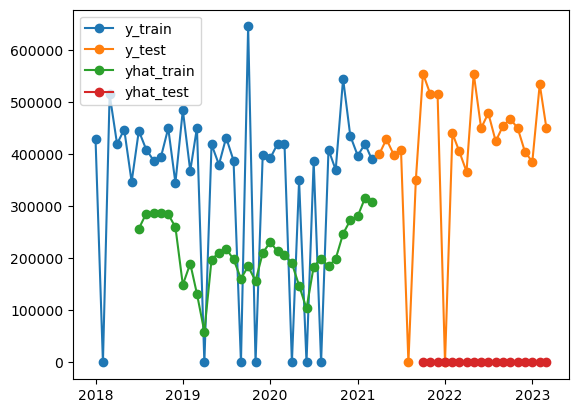

452249.18831694254

In [41]:
evaluate_lstm(
    model=model_1,
    X_train=train_lstm_dataset_dict[1],
    X_test=test_lstm_dataset_dict[1],
    district_no=1,
    lookback=lookback,
)


# LSTM on all districts

district_no 1
Epoch 1/20


2023-04-05 21:49:35.469426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:36.766025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:37.803945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:38.597822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:39.756175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:40.787026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:49:41.600486: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 31s 624ms/step - loss: 0.1977
Epoch 2/20
33/33 [==============================] - 10s 312ms/step - loss: 0.1644
Epoch 3/20
33/33 [==============================] - 8s 250ms/step - loss: 0.1635
Epoch 4/20
33/33 [==============================] - 8s 238ms/step - loss: 0.1548
Epoch 5/20
33/33 [==============================] - 8s 226ms/step - loss: 0.1507
Epoch 6/20
33/33 [==============================] - 8s 232ms/step - loss: 0.1474
Epoch 7/20
33/33 [==============================] - 8s 231ms/step - loss: 0.1648
Epoch 8/20
33/33 [==============================] - 8s 230ms/step - loss: 0.1487
Epoch 9/20
33/33 [==============================] - 8s 229ms/step - loss: 0.1558
Epoch 10/20
33/33 [==============================] - 7s 224ms/step - loss: 0.1465
Epoch 11/20
33/33 [==============================] - 8s 231ms/step - loss: 0.1427
Epoch 12/20
33/33 [==============================] - 8s 226ms/step - loss: 0.1420
Epoch 13/20
33/33 [===============

2023-04-05 21:52:36.301076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:37.072759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:37.778931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:38.401592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 50ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 171770.00 RMSE
Test Score: 452249.19 RMSE


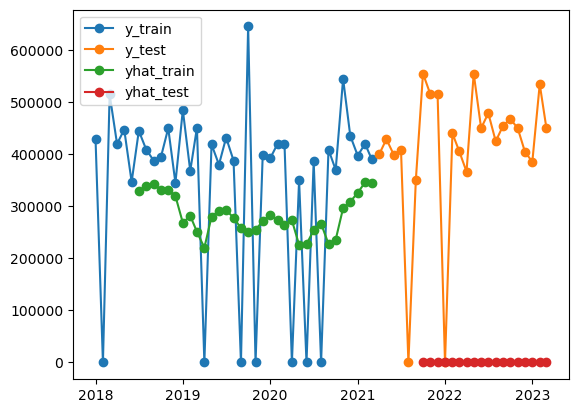

district_no 2
Epoch 1/20


2023-04-05 21:52:51.336422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:53.063064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:54.404436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:55.282639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:56.299260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:57.507352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:52:58.312199: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 27s 439ms/step - loss: 0.1973
Epoch 2/20
33/33 [==============================] - 4s 104ms/step - loss: 0.1579
Epoch 3/20
33/33 [==============================] - 4s 110ms/step - loss: 0.1552
Epoch 4/20
33/33 [==============================] - 3s 98ms/step - loss: 0.1544
Epoch 5/20
33/33 [==============================] - 4s 121ms/step - loss: 0.1575
Epoch 6/20
33/33 [==============================] - 3s 100ms/step - loss: 0.1553
Epoch 7/20
33/33 [==============================] - 3s 89ms/step - loss: 0.1526
Epoch 8/20
33/33 [==============================] - 3s 88ms/step - loss: 0.1536
Epoch 9/20
33/33 [==============================] - 3s 97ms/step - loss: 0.1554
Epoch 10/20
33/33 [==============================] - 3s 86ms/step - loss: 0.1531
Epoch 11/20
33/33 [==============================] - 3s 77ms/step - loss: 0.1534
Epoch 12/20
33/33 [==============================] - 3s 79ms/step - loss: 0.1526
Epoch 13/20
33/33 [=======================

2023-04-05 21:54:12.620662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:13.454079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:14.002741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:14.711060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 326454.82 RMSE
Test Score: 942151.45 RMSE


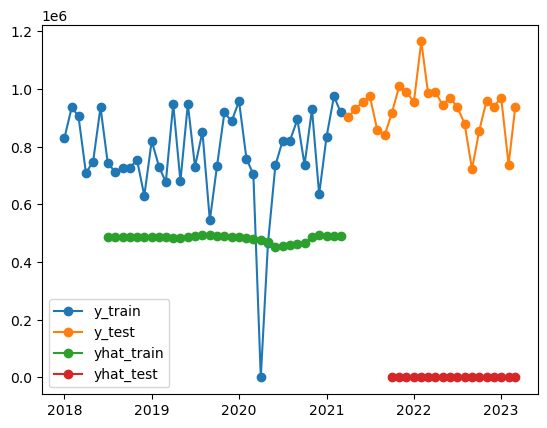

district_no 3
Epoch 1/20


2023-04-05 21:54:27.556343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:28.862028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:29.716279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:30.340455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:31.321705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:32.069263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:54:32.816306: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 18s 198ms/step - loss: 0.1206
Epoch 2/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0945
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0948
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0933
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0938
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0932
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0953
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0931
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0925
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0946
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0970
Epoch 12/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0935
Epoch 13/20
33/33 [===========================

2023-04-05 21:55:09.108604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:09.973297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:10.512212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:11.130578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 55747.41 RMSE
Test Score: 187180.72 RMSE


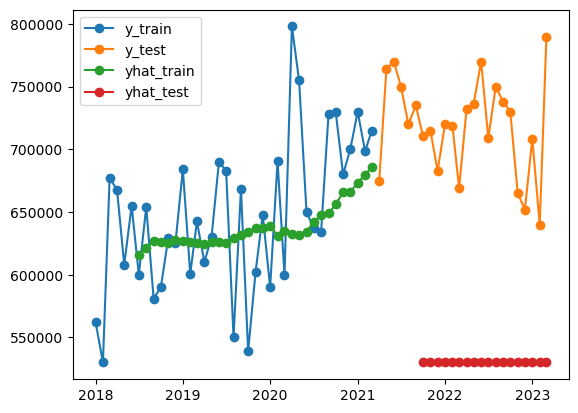

district_no 4
Epoch 1/20


2023-04-05 21:55:21.240982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:22.531412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:23.172299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:23.798383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:24.698121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:25.415958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:55:26.203792: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 18s 193ms/step - loss: 0.0888
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0804
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0795
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0799
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0793
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0796
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0792
Epoch 8/20
33/33 [==============================] - 2s 59ms/step - loss: 0.0829
Epoch 9/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0789
Epoch 10/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0791
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0790
Epoch 12/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0798
Epoch 13/20
33/33 [===========================

2023-04-05 21:56:03.504391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:04.349898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:04.858111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:05.343222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 86766.32 RMSE
Test Score: 270948.23 RMSE


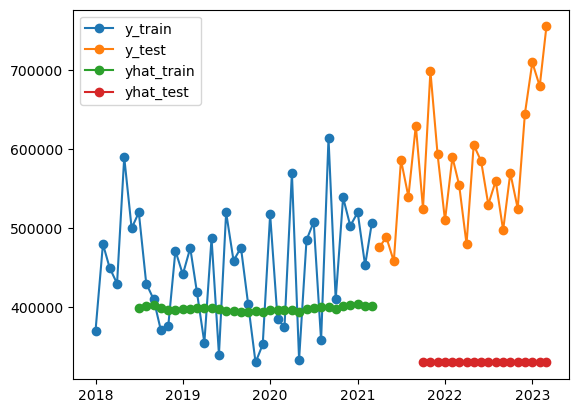

district_no 5
Epoch 1/20


2023-04-05 21:56:15.571702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:16.805856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:17.600217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:18.184278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:19.188265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:19.930461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:20.780514: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 16s 201ms/step - loss: 0.1125
Epoch 2/20
33/33 [==============================] - 2s 48ms/step - loss: 0.1014
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1009
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0975
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0966
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0953
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0952
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0974
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0968
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0937
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0956
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0934
Epoch 13/20
33/33 [===========================

2023-04-05 21:56:57.811363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:58.701109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:59.122633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:56:59.726664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 72436.61 RMSE
Test Score: 244527.72 RMSE


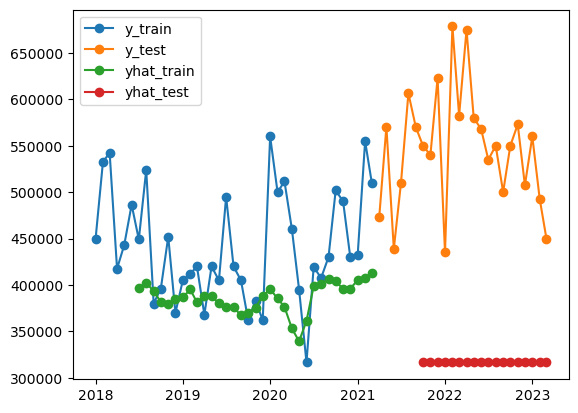

district_no 7
Epoch 1/20


2023-04-05 21:57:08.923037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:57:10.107573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:57:11.059893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:57:11.879972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:57:12.956829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:57:13.721672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:57:14.441391: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 22s 341ms/step - loss: 0.1925
Epoch 2/20
33/33 [==============================] - 4s 114ms/step - loss: 0.1580
Epoch 3/20
33/33 [==============================] - 3s 99ms/step - loss: 0.1582
Epoch 4/20
33/33 [==============================] - 3s 98ms/step - loss: 0.1582
Epoch 5/20
33/33 [==============================] - 3s 90ms/step - loss: 0.1606
Epoch 6/20
33/33 [==============================] - 3s 77ms/step - loss: 0.1592
Epoch 7/20
33/33 [==============================] - 3s 88ms/step - loss: 0.1612
Epoch 8/20
33/33 [==============================] - 3s 82ms/step - loss: 0.1558
Epoch 9/20
33/33 [==============================] - 3s 73ms/step - loss: 0.1565
Epoch 10/20
33/33 [==============================] - 3s 86ms/step - loss: 0.1523
Epoch 11/20
33/33 [==============================] - 3s 87ms/step - loss: 0.1532
Epoch 12/20
33/33 [==============================] - 3s 84ms/step - loss: 0.1529
Epoch 13/20
33/33 [==========================

2023-04-05 21:58:21.467705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:22.270141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:22.906136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:23.325211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 20ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 205621.63 RMSE
Test Score: 478284.92 RMSE


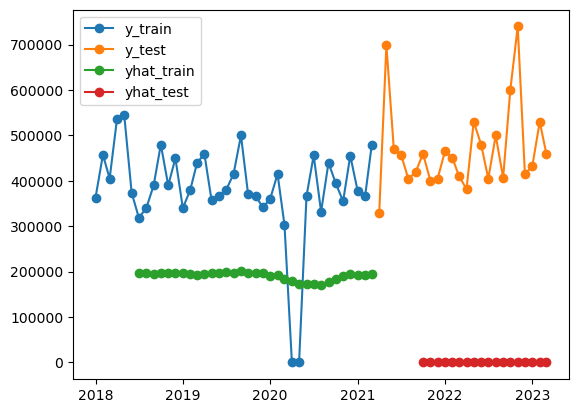

district_no 8
Epoch 1/20


2023-04-05 21:58:35.378069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:36.711910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:37.648625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:38.228636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:39.117051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:39.822060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:58:40.544517: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 24s 407ms/step - loss: 0.1812
Epoch 2/20
33/33 [==============================] - 4s 123ms/step - loss: 0.1287
Epoch 3/20
33/33 [==============================] - 3s 102ms/step - loss: 0.1300
Epoch 4/20
33/33 [==============================] - 3s 104ms/step - loss: 0.1319
Epoch 5/20
33/33 [==============================] - 3s 93ms/step - loss: 0.1305
Epoch 6/20
33/33 [==============================] - 3s 83ms/step - loss: 0.1313
Epoch 7/20
33/33 [==============================] - 3s 84ms/step - loss: 0.1334
Epoch 8/20
33/33 [==============================] - 3s 83ms/step - loss: 0.1310
Epoch 9/20
33/33 [==============================] - 3s 83ms/step - loss: 0.1298
Epoch 10/20
33/33 [==============================] - 3s 83ms/step - loss: 0.1287
Epoch 11/20
33/33 [==============================] - 3s 86ms/step - loss: 0.1306
Epoch 12/20
33/33 [==============================] - 3s 83ms/step - loss: 0.1278
Epoch 13/20
33/33 [========================

2023-04-05 21:59:50.610554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:59:51.317436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:59:51.867776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 21:59:52.483046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 168837.04 RMSE
Test Score: 572042.35 RMSE


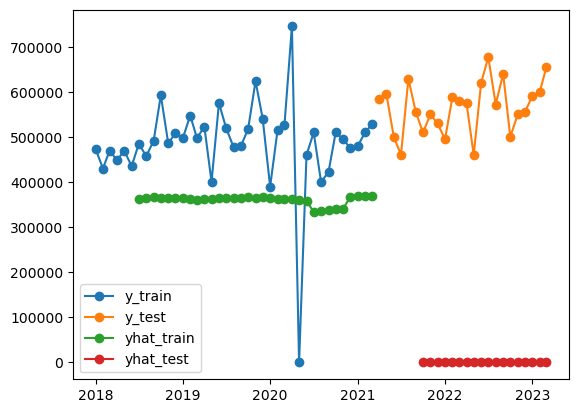

district_no 10
Epoch 1/20


2023-04-05 22:00:06.652293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:07.967347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:08.783911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:09.466781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:10.364181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:11.186518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:11.920030: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 19s 226ms/step - loss: 0.0713
Epoch 2/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0649
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0647
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0637
Epoch 5/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0646
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0638
Epoch 7/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0653
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0638
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0639
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0630
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0632
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0643
Epoch 13/20
33/33 [===========================

2023-04-05 22:00:48.196913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:49.138227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:49.911359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:00:50.716089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 22ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 61802.22 RMSE
Test Score: 275993.26 RMSE


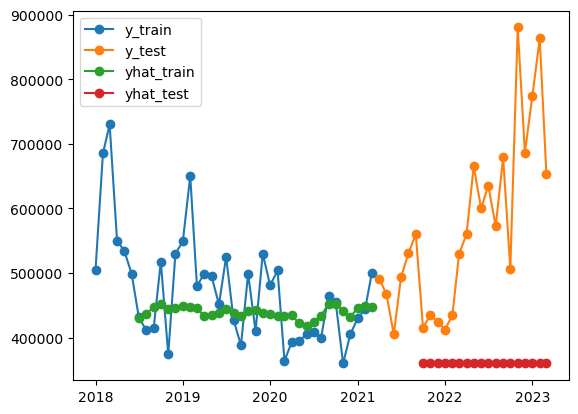

district_no 11
Epoch 1/20


2023-04-05 22:01:02.777455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:01:04.016147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:01:05.293627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:01:06.391458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:01:08.147630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:01:09.269889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:01:10.238089: I tensorflow/core/grappler/optimizers/cust

21/21 [==============================] - 32s 882ms/step - loss: 0.1294
Epoch 2/20
21/21 [==============================] - 8s 363ms/step - loss: 0.1240
Epoch 3/20
21/21 [==============================] - 7s 347ms/step - loss: 0.1191
Epoch 4/20
21/21 [==============================] - 7s 333ms/step - loss: 0.1157
Epoch 5/20
21/21 [==============================] - 7s 349ms/step - loss: 0.1118
Epoch 6/20
21/21 [==============================] - 7s 351ms/step - loss: 0.1073
Epoch 7/20
21/21 [==============================] - 7s 347ms/step - loss: 0.1059
Epoch 8/20
21/21 [==============================] - 7s 315ms/step - loss: 0.1050
Epoch 9/20
21/21 [==============================] - 6s 309ms/step - loss: 0.1075
Epoch 10/20
21/21 [==============================] - 7s 331ms/step - loss: 0.0989
Epoch 11/20
21/21 [==============================] - 7s 318ms/step - loss: 0.0991
Epoch 12/20
21/21 [==============================] - 7s 319ms/step - loss: 0.0954
Epoch 13/20
21/21 [================

2023-04-05 22:03:41.755462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:03:42.447841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:03:43.436366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:03:44.343917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 72ms/step
yhat train shape (21, 10)
yhat test shape (18, 10)
y train shape (21,)
y test shape (18,)
Train Score: 228608.28 RMSE
Test Score: 250991.04 RMSE
model for district 11 cannot be evaluated
district_no 12
Epoch 1/20


2023-04-05 22:03:59.115694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:00.603836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:01.494527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:02.702438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:04.532389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:05.599036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:06.769793: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 25s 367ms/step - loss: 0.1185
Epoch 2/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0933
Epoch 3/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0924
Epoch 4/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0926
Epoch 5/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0925
Epoch 6/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0937
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0915
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0922
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0914
Epoch 10/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0914
Epoch 11/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0909
Epoch 12/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0894
Epoch 13/20
33/33 [===========================

2023-04-05 22:04:53.199069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:54.067845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:54.972000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:04:55.783436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 86167.13 RMSE
Test Score: 346430.90 RMSE


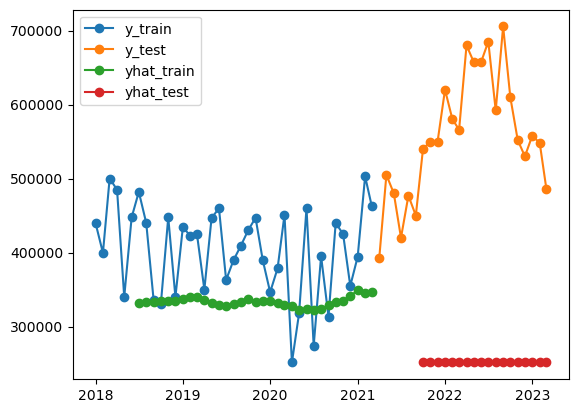

district_no 13
Epoch 1/20


2023-04-05 22:05:06.716875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:08.293011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:09.259133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:10.170325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:11.411841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:12.780377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:13.950970: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 23s 289ms/step - loss: 0.0941
Epoch 2/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0699
Epoch 3/20
33/33 [==============================] - 2s 54ms/step - loss: 0.0691
Epoch 4/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0732
Epoch 5/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0686
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0687
Epoch 7/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0686
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0684
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0669
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0692
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0678
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0693
Epoch 13/20
33/33 [===========================

2023-04-05 22:05:54.500668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:55.380057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:56.251544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:05:56.827983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 81215.88 RMSE
Test Score: 223126.43 RMSE


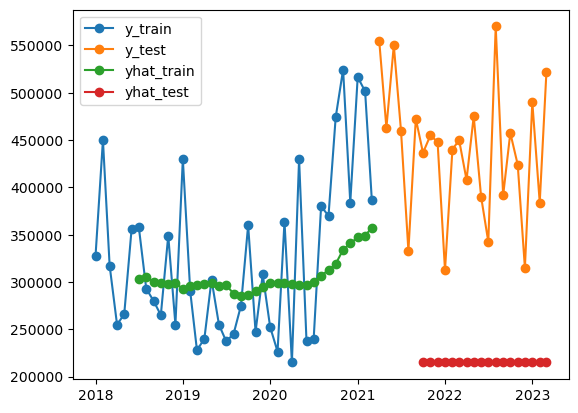

district_no 14
Epoch 1/20


2023-04-05 22:06:09.431749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:06:10.913580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:06:12.013093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:06:13.045732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:06:14.407909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:06:15.530010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:06:16.603883: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 25s 327ms/step - loss: 0.0961
Epoch 2/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0845
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0821
Epoch 4/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0816
Epoch 5/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0838
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0817
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0821
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0818
Epoch 9/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0821
Epoch 10/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0815
Epoch 11/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0814
Epoch 12/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0828
Epoch 13/20
33/33 [===========================

2023-04-05 22:06:59.601307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:00.756415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:01.758570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:02.455165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 70254.56 RMSE
Test Score: 200349.75 RMSE


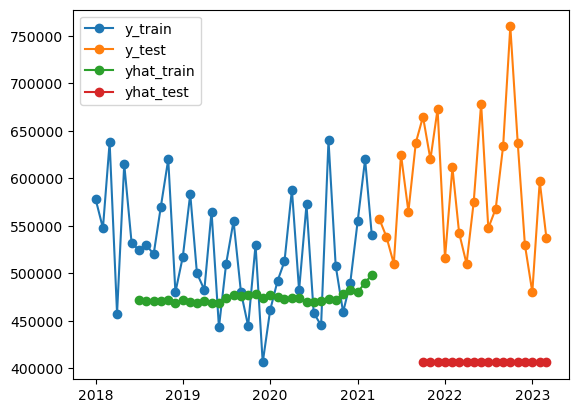

district_no 15
Epoch 1/20


2023-04-05 22:07:13.913714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:15.328328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:16.097439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:16.880075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:18.243229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:19.135626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:07:19.895028: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 22s 288ms/step - loss: 0.1248
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1019
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1016
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1006
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0995
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0992
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1000
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1001
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0974
Epoch 10/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0998
Epoch 11/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0988
Epoch 12/20
33/33 [==============================] - 2s 53ms/step - loss: 0.0987
Epoch 13/20
33/33 [===========================

2023-04-05 22:08:00.873735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:01.733306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:02.643206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:03.421634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 61816.24 RMSE
Test Score: 166301.78 RMSE


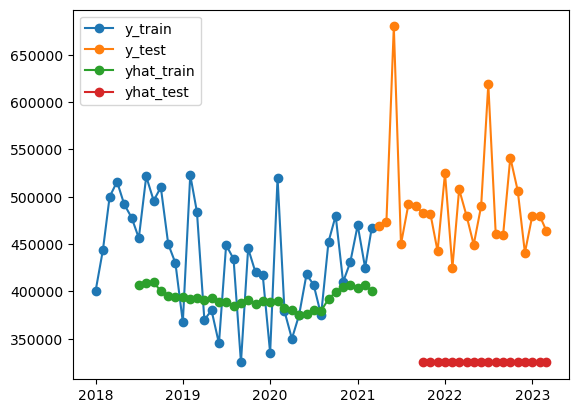

district_no 16
Epoch 1/20


2023-04-05 22:08:16.874978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:18.271715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:19.257941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:20.190320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:21.797435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:23.037254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:08:24.673977: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 25s 352ms/step - loss: 0.0995
Epoch 2/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0772
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0775
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0794
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0780
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0777
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0762
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0776
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0757
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0767
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0744
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0738
Epoch 13/20
33/33 [===========================

2023-04-05 22:09:05.695795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:06.539057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:07.358962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:08.157535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 14ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 22361.55 RMSE
Test Score: 122154.39 RMSE


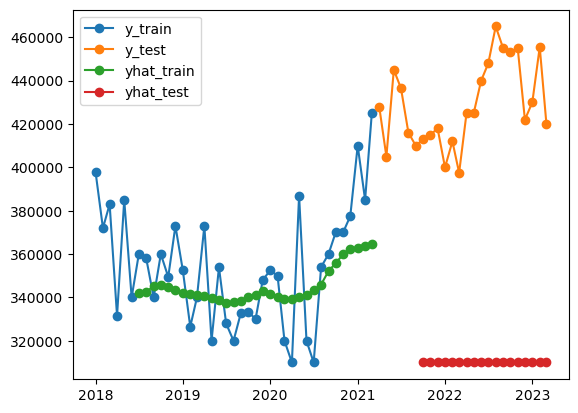

district_no 17
Epoch 1/20


2023-04-05 22:09:20.306600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:21.740450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:23.066949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:24.337150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:26.063578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:27.231572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:09:28.363911: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 40s 814ms/step - loss: 0.1450
Epoch 2/20
33/33 [==============================] - 14s 432ms/step - loss: 0.1336
Epoch 3/20
33/33 [==============================] - 12s 351ms/step - loss: 0.1297
Epoch 4/20
33/33 [==============================] - 10s 317ms/step - loss: 0.1274
Epoch 5/20
33/33 [==============================] - 11s 332ms/step - loss: 0.1243
Epoch 6/20
33/33 [==============================] - 11s 316ms/step - loss: 0.1227
Epoch 7/20
33/33 [==============================] - 11s 323ms/step - loss: 0.1243
Epoch 8/20
33/33 [==============================] - 11s 342ms/step - loss: 0.1194
Epoch 9/20
33/33 [==============================] - 11s 330ms/step - loss: 0.1112
Epoch 10/20
33/33 [==============================] - 10s 310ms/step - loss: 0.1110
Epoch 11/20
33/33 [==============================] - 11s 335ms/step - loss: 0.1111
Epoch 12/20
33/33 [==============================] - 11s 318ms/step - loss: 0.1062
Epoch 13/20
33/33 [=====

2023-04-05 22:13:33.960555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:13:34.954030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:13:36.135839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:13:37.504095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 2s 97ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 147414.11 RMSE
Test Score: 246199.22 RMSE


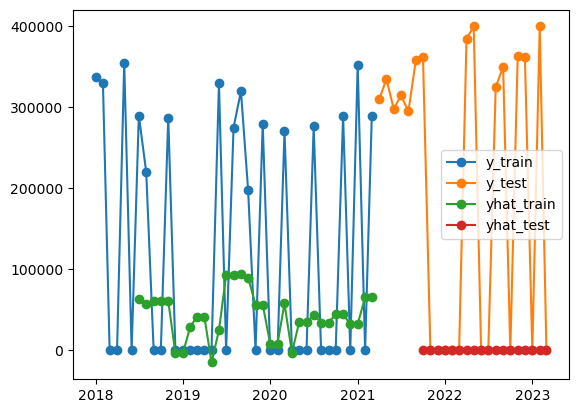

district_no 18
Epoch 1/20


2023-04-05 22:13:59.417032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:01.107431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:02.261160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:03.599564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:05.432827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:06.841348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:08.451136: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 32s 471ms/step - loss: 0.1127
Epoch 2/20
33/33 [==============================] - 2s 44ms/step - loss: 0.1026
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1019
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1025
Epoch 5/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1014
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1020
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1021
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1014
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0995
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1000
Epoch 11/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0986
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0983
Epoch 13/20
33/33 [===========================

2023-04-05 22:14:54.481851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:55.369126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:56.312655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:14:57.032060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 20149.14 RMSE
Test Score: 134166.01 RMSE


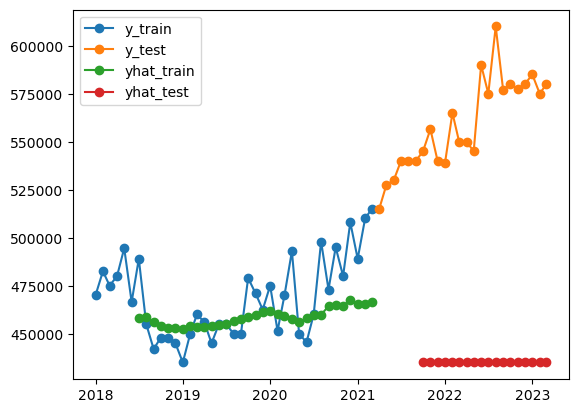

district_no 19
Epoch 1/20


2023-04-05 22:15:10.551835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:15:12.093784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:15:13.167328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:15:14.293269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:15:15.924853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:15:17.812160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:15:20.084591: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 39s 670ms/step - loss: 0.1068
Epoch 2/20
33/33 [==============================] - 2s 60ms/step - loss: 0.0876
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0874
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0893
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0903
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0885
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0861
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0863
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0877
Epoch 10/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0855
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0861
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0856
Epoch 13/20
33/33 [===========================

2023-04-05 22:16:14.056133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:14.970489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:15.757860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:16.593255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 13567.75 RMSE
Test Score: 127446.46 RMSE


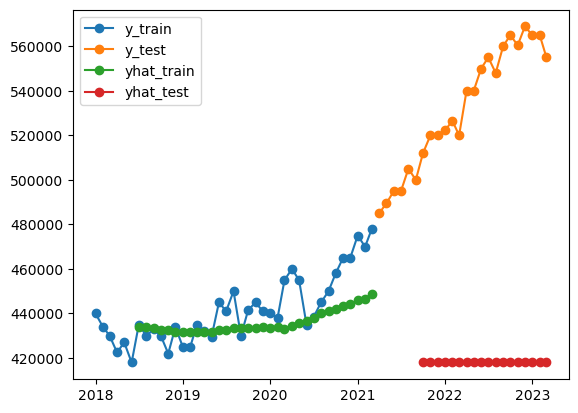

district_no 20
Epoch 1/20


2023-04-05 22:16:30.294991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:31.674668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:32.604927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:33.541216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:35.094471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:36.283977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:16:37.481861: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 29s 426ms/step - loss: 0.1176
Epoch 2/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0964
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0984
Epoch 4/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0979
Epoch 5/20
33/33 [==============================] - 2s 57ms/step - loss: 0.0962
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0974
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0955
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0958
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0951
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0960
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0947
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0948
Epoch 13/20
33/33 [===========================

2023-04-05 22:17:22.496981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:23.230641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:23.895694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:24.747162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 26ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 41462.27 RMSE
Test Score: 180012.60 RMSE


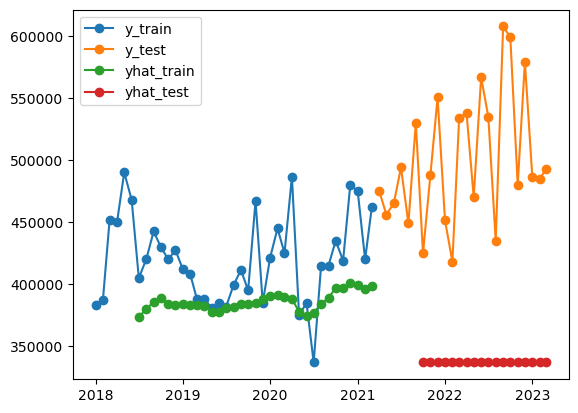

district_no 21
Epoch 1/20


2023-04-05 22:17:38.203013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:39.662525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:40.737634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:41.624836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:43.442054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:44.573567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:17:46.063712: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 25s 380ms/step - loss: 0.1621
Epoch 2/20
33/33 [==============================] - 2s 71ms/step - loss: 0.1397
Epoch 3/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1378
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1383
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1422
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1389
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1375
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1377
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1382
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1379
Epoch 11/20
33/33 [==============================] - 2s 54ms/step - loss: 0.1382
Epoch 12/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1370
Epoch 13/20
33/33 [===========================

2023-04-05 22:18:30.017624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:30.763667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:31.623723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:32.469158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 303623.79 RMSE
Test Score: 532719.12 RMSE


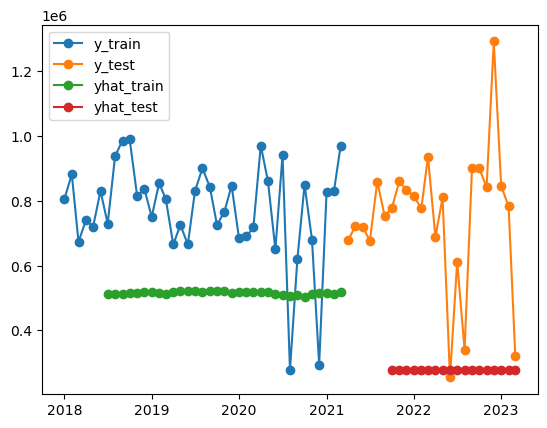

district_no 22
Epoch 1/20


2023-04-05 22:18:45.836003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:47.400083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:48.599201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:49.687131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:51.419830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:52.624170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:18:54.013546: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 27s 411ms/step - loss: 0.1186
Epoch 2/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0934
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0915
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0921
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0914
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0905
Epoch 7/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0902
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0912
Epoch 9/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0914
Epoch 10/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0889
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0896
Epoch 12/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0901
Epoch 13/20
33/33 [===========================

2023-04-05 22:19:40.619651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:19:41.865984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:19:42.965221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:19:44.120974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 22558.56 RMSE
Test Score: 124156.83 RMSE


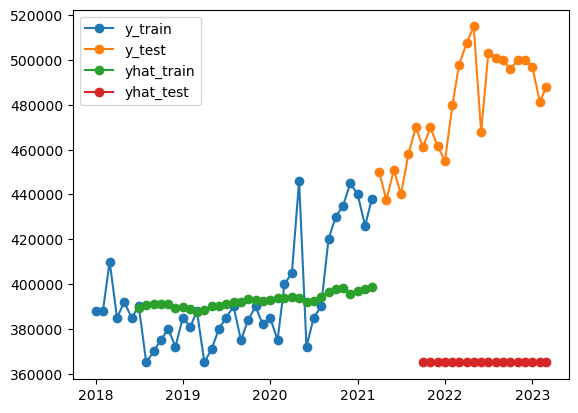

district_no 23
Epoch 1/20


2023-04-05 22:19:59.640873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:01.235991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:02.776615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:03.863206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:05.581333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:06.992250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:08.698532: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 30s 439ms/step - loss: 0.1205
Epoch 2/20
33/33 [==============================] - 2s 54ms/step - loss: 0.0987
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0996
Epoch 4/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0974
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0983
Epoch 6/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0973
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0979
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1034
Epoch 9/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0986
Epoch 10/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0981
Epoch 11/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0958
Epoch 12/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0957
Epoch 13/20
33/33 [===========================

2023-04-05 22:20:55.579743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:56.321969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:57.052048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:20:58.009163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 20ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 24396.93 RMSE
Test Score: 159013.19 RMSE


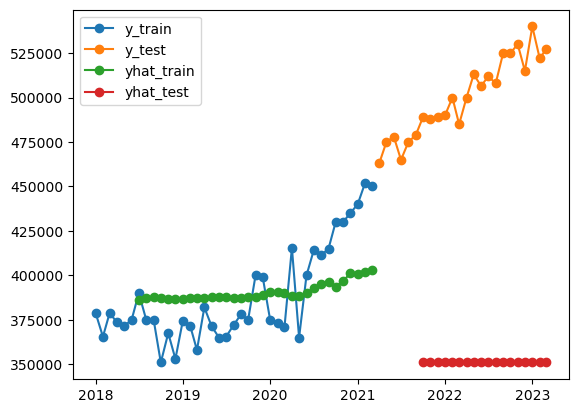

district_no 25
Epoch 1/20


2023-04-05 22:21:10.830767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:21:12.469631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:21:13.595583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:21:14.778221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:21:16.490445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:21:17.909411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:21:19.360247: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 28s 382ms/step - loss: 0.1029
Epoch 2/20
33/33 [==============================] - 2s 60ms/step - loss: 0.0960
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0949
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0949
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0944
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0949
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0943
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0942
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0938
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0945
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0940
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0956
Epoch 13/20
33/33 [===========================

2023-04-05 22:22:02.231261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:03.135539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:04.057657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:05.109905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 25153.00 RMSE
Test Score: 164809.10 RMSE


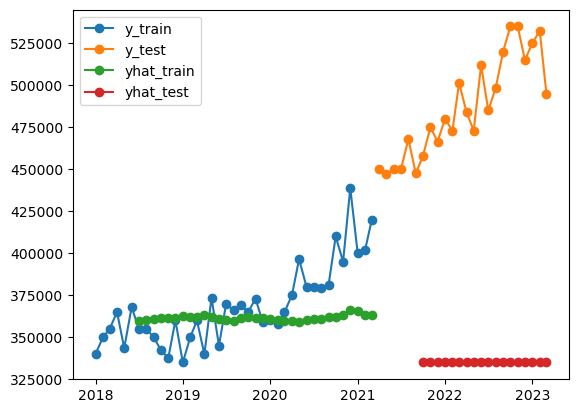

district_no 27
Epoch 1/20


2023-04-05 22:22:17.867958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:19.769574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:21.319410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:22.372541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:24.020224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:25.187533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:22:26.489155: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 26s 339ms/step - loss: 0.1512
Epoch 2/20
33/33 [==============================] - 2s 54ms/step - loss: 0.1319
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1309
Epoch 4/20
33/33 [==============================] - 2s 54ms/step - loss: 0.1317
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1327
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1323
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1316
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1296
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1293
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1307
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.1299
Epoch 12/20
33/33 [==============================] - 2s 55ms/step - loss: 0.1301
Epoch 13/20
33/33 [===========================

2023-04-05 22:23:09.023130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:09.821655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:10.493624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:11.509506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 23541.97 RMSE
Test Score: 146544.76 RMSE


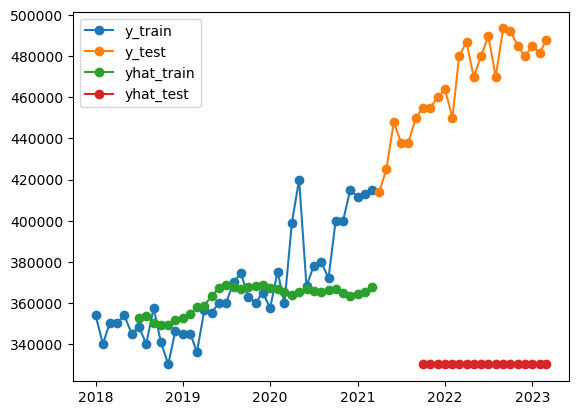

district_no 28
Epoch 1/20


2023-04-05 22:23:25.225179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:26.683044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:27.945804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:28.991215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:30.492265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:31.946267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:23:33.276589: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 31s 481ms/step - loss: 0.1139
Epoch 2/20
33/33 [==============================] - 3s 77ms/step - loss: 0.0974
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0965
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0972
Epoch 5/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0947
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0957
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0961
Epoch 8/20
33/33 [==============================] - 2s 56ms/step - loss: 0.0946
Epoch 9/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0952
Epoch 10/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0972
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0965
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0937
Epoch 13/20
33/33 [===========================

2023-04-05 22:24:20.655626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:21.490846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:22.227961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:23.415702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 21ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 15973.37 RMSE
Test Score: 131064.18 RMSE


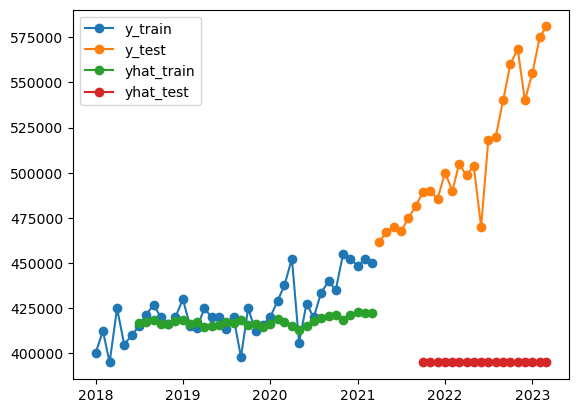

In [42]:
# run the model for all districts
district_no_list = list(train_lstm_df_dict.keys())
test_score_dict = {}
for district_no in district_no_list:
    print("district_no", district_no)
    model = fit_lstm(train_lstm_dataset_dict[district_no])
    test_score = evaluate_lstm(
        model=model,
        X_train=train_lstm_dataset_dict[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict[district_no] = test_score       

In [43]:
test_score_dict

{1: 452249.18831694254,
 2: 942151.447460545,
 3: 187180.71654479322,
 4: 270948.2255864475,
 5: 244527.71940120726,
 7: 478284.91573119885,
 8: 572042.3544482233,
 10: 275993.260684226,
 11: None,
 12: 346430.9018112815,
 13: 223126.4277887713,
 14: 200349.74969898126,
 15: 166301.78306190658,
 16: 122154.38774126963,
 17: 246199.21737949896,
 18: 134166.00738554375,
 19: 127446.458078154,
 20: 180012.6032970408,
 21: 532719.1249721668,
 22: 124156.82760480347,
 23: 159013.18952981368,
 25: 164809.1000049586,
 27: 146544.76452606556,
 28: 131064.1789930075}

# LSTM Model with linear interpolation

district_no 1 linear interpolation applied
Epoch 1/20


2023-04-05 22:24:38.877973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:40.477175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:41.523657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:42.830153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:45.113036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:46.530830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:24:48.012783: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 31s 517ms/step - loss: 0.0831
Epoch 2/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0770
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0762
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0737
Epoch 5/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0763
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0748
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0738
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0728
Epoch 9/20
33/33 [==============================] - 2s 60ms/step - loss: 0.0738
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0727
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0732
Epoch 12/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0732
Epoch 13/20
33/33 [===========================

2023-04-05 22:25:38.045669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:25:39.467760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:25:40.613389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:25:41.484723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 8s 323ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 60777.52 RMSE
Test Score: 149832.67 RMSE


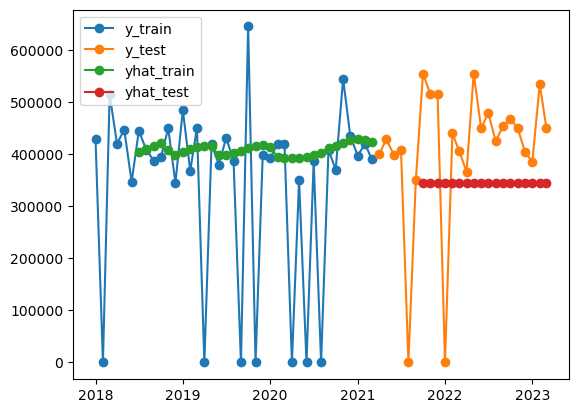

district_no 2 linear interpolation applied
Epoch 1/20


2023-04-05 22:26:03.346730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:04.995350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:06.125418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:07.088662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:08.855893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:10.743043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:13.049474: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 29s 390ms/step - loss: 0.1429
Epoch 2/20
33/33 [==============================] - 2s 52ms/step - loss: 0.1210
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1170
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1169
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1170
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1206
Epoch 7/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1169
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1155
Epoch 9/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1160
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1157
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1150
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1146
Epoch 13/20
33/33 [===========================

2023-04-05 22:26:56.170840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:57.000081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:57.921613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:26:58.789477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 27ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 164571.26 RMSE
Test Score: 481880.60 RMSE


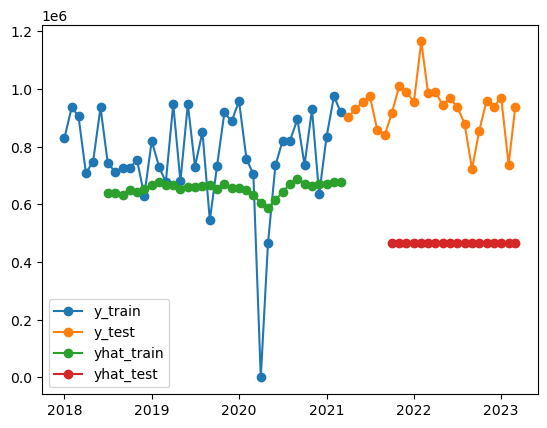

district_no 3 linear interpolation applied
Epoch 1/20


2023-04-05 22:27:13.469554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:27:15.001250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:27:16.431697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:27:17.530705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:27:19.067759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:27:20.344770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:27:21.560533: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 31s 472ms/step - loss: 0.1073
Epoch 2/20
33/33 [==============================] - 2s 55ms/step - loss: 0.0951
Epoch 3/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0936
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0934
Epoch 5/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0933
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0932
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0932
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0924
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0938
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0962
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0925
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0915
Epoch 13/20
33/33 [===========================

2023-04-05 22:28:07.875465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:08.656265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:09.940840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:10.797087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 62368.48 RMSE
Test Score: 187180.72 RMSE


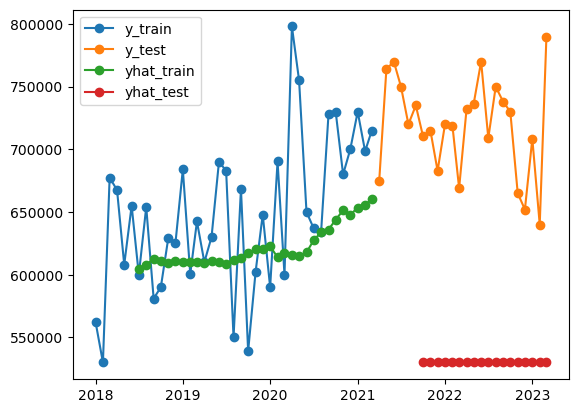

district_no 4 linear interpolation applied
Epoch 1/20


2023-04-05 22:28:23.441277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:25.147137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:26.407056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:27.532245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:29.225777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:30.557800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:28:32.340635: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 34s 558ms/step - loss: 0.0897
Epoch 2/20
33/33 [==============================] - 3s 80ms/step - loss: 0.0800
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0800
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0804
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0803
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0813
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0792
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0803
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0792
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0794
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0796
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0791
Epoch 13/20
33/33 [===========================

2023-04-05 22:29:22.070798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:22.797368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:23.721910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:24.757253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 82855.43 RMSE
Test Score: 270948.23 RMSE


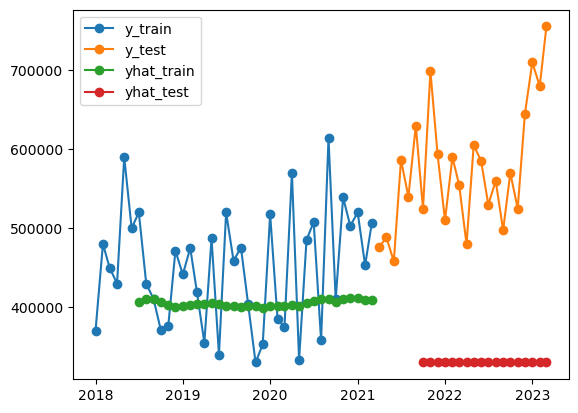

district_no 5 linear interpolation applied
Epoch 1/20


2023-04-05 22:29:38.952040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:41.008334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:42.238617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:43.518831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:45.465151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:47.034354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:29:48.422911: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 35s 548ms/step - loss: 0.1162
Epoch 2/20
33/33 [==============================] - 2s 53ms/step - loss: 0.1007
Epoch 3/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0976
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0983
Epoch 5/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0960
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0984
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0960
Epoch 8/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0946
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0944
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0959
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0963
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0941
Epoch 13/20
33/33 [===========================

2023-04-05 22:30:36.929780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:30:37.805638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:30:38.676219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:30:40.064654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 20ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 68530.80 RMSE
Test Score: 244527.72 RMSE


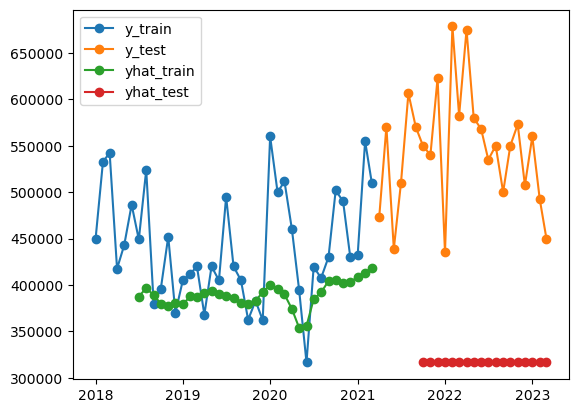

district_no 7 linear interpolation applied
Epoch 1/20


2023-04-05 22:30:54.154315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:30:55.811853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:30:57.778998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:30:59.085052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:31:00.901872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:31:02.377680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:31:03.649829: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 31s 412ms/step - loss: 0.1019
Epoch 2/20
33/33 [==============================] - 2s 56ms/step - loss: 0.0891
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0901
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0910
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0907
Epoch 6/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0911
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0891
Epoch 8/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0907
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0905
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0896
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0890
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0900
Epoch 13/20
33/33 [===========================

2023-04-05 22:31:47.914203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:31:48.921878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:31:49.826482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:31:50.741360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 50815.16 RMSE
Test Score: 188147.55 RMSE


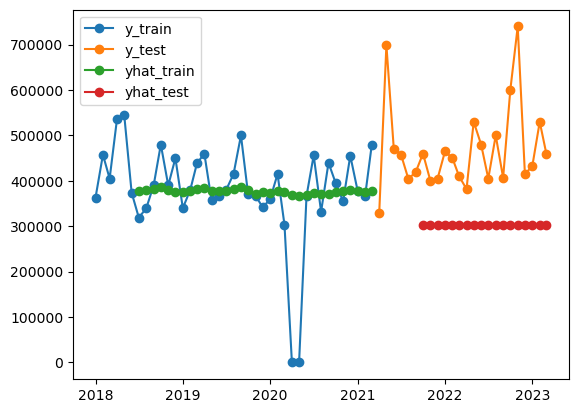

district_no 8 linear interpolation applied
Epoch 1/20


2023-04-05 22:32:05.799592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:32:07.428638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:32:08.798821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:32:10.076211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:32:11.818204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:32:13.267610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:32:14.633872: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 40s 721ms/step - loss: 0.1073
Epoch 2/20
33/33 [==============================] - 2s 56ms/step - loss: 0.0873
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0883
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0878
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0874
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0878
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0872
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0866
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0882
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0873
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0873
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0861
Epoch 13/20
33/33 [===========================

2023-04-05 22:33:12.410119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:14.063931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:15.395276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:16.808785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 36ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 66339.75 RMSE
Test Score: 187852.82 RMSE


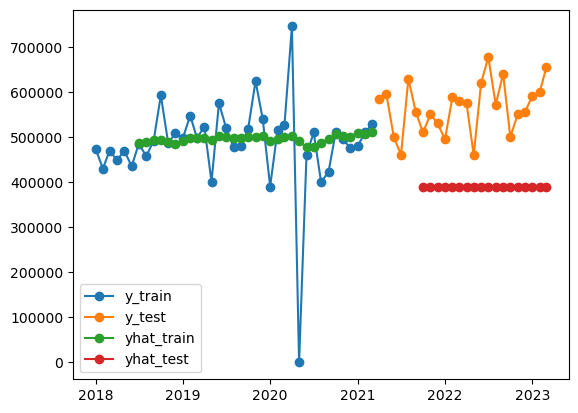

district_no 10 linear interpolation applied
Epoch 1/20


2023-04-05 22:33:35.049430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:36.727879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:38.006921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:39.700189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:41.815285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:43.432990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:33:45.097108: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 38s 658ms/step - loss: 0.0739
Epoch 2/20
33/33 [==============================] - 2s 53ms/step - loss: 0.0645
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0639
Epoch 4/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0644
Epoch 5/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0636
Epoch 6/20
33/33 [==============================] - 2s 52ms/step - loss: 0.0636
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0658
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0636
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0630
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0626
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0644
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0629
Epoch 13/20
33/33 [===========================

2023-04-05 22:34:37.979379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:34:38.771230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:34:39.693580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:34:40.875664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 60988.91 RMSE
Test Score: 275993.26 RMSE


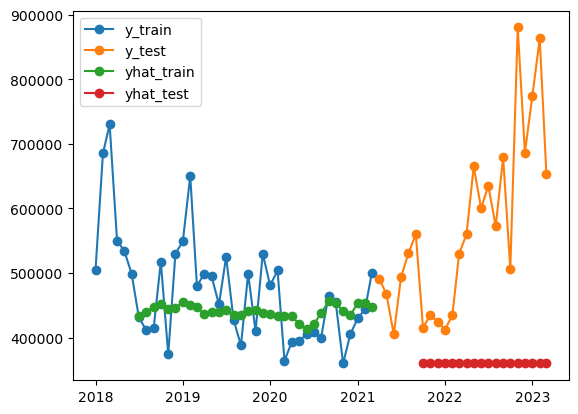

district_no 11 linear interpolation applied
Epoch 1/20


2023-04-05 22:34:55.829872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:34:57.577523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:34:59.236110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:35:00.729244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:35:02.629795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:35:04.098872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:35:05.526194: I tensorflow/core/grappler/optimizers/cust

21/21 [==============================] - 37s 948ms/step - loss: nan
Epoch 2/20
21/21 [==============================] - 4s 187ms/step - loss: nan
Epoch 3/20
21/21 [==============================] - 1s 65ms/step - loss: nan
Epoch 4/20
21/21 [==============================] - 1s 53ms/step - loss: nan
Epoch 5/20
21/21 [==============================] - 1s 45ms/step - loss: nan
Epoch 6/20
21/21 [==============================] - 1s 45ms/step - loss: nan
Epoch 7/20
21/21 [==============================] - 1s 47ms/step - loss: nan
Epoch 8/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 9/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 10/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epoch 11/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 12/20
21/21 [==============================] - 1s 42ms/step - loss: nan
Epoch 13/20
21/21 [==============================] - 1s 43ms/step - loss: nan
Epo

2023-04-05 22:35:48.524101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:35:49.521709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:35:50.493271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:35:51.499503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 9s 363ms/step
yhat train shape (21, 10)
yhat test shape (18, 10)
y train shape (21,)
y test shape (18,)
model for district 11 cannot be evaluated
district_no 12 linear interpolation applied
Epoch 1/20


2023-04-05 22:36:15.355799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:36:16.944094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:36:18.389702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:36:20.170030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:36:22.000508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:36:23.793204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:36:25.557013: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 33s 466ms/step - loss: 0.1084
Epoch 2/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0964
Epoch 3/20
33/33 [==============================] - 2s 62ms/step - loss: 0.0974
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0920
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0946
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0934
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0908
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0912
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0911
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0905
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0897
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0927
Epoch 13/20
33/33 [===========================

2023-04-05 22:37:10.940121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:11.977985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:12.745458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:13.645194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 96148.52 RMSE
Test Score: 346430.90 RMSE


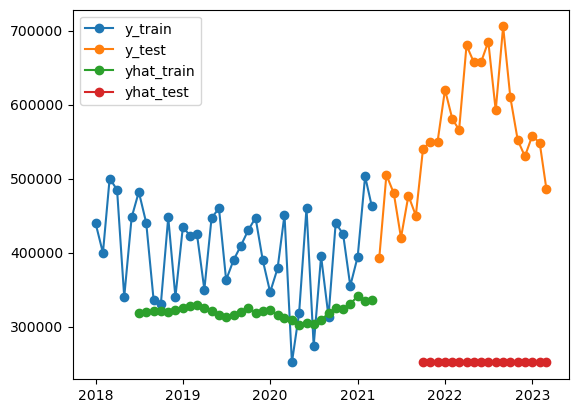

district_no 13 linear interpolation applied
Epoch 1/20


2023-04-05 22:37:27.129657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:28.652874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:29.869681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:31.055624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:32.672169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:34.128554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:37:35.761405: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 32s 492ms/step - loss: 0.0758
Epoch 2/20
33/33 [==============================] - 2s 52ms/step - loss: 0.0709
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0712
Epoch 4/20
33/33 [==============================] - 2s 49ms/step - loss: 0.0695
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0697
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0683
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0683
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0673
Epoch 9/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0702
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0761
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0671
Epoch 12/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0684
Epoch 13/20
33/33 [===========================

2023-04-05 22:38:22.001284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:23.026099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:24.007500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:24.904591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 92510.06 RMSE
Test Score: 223126.43 RMSE


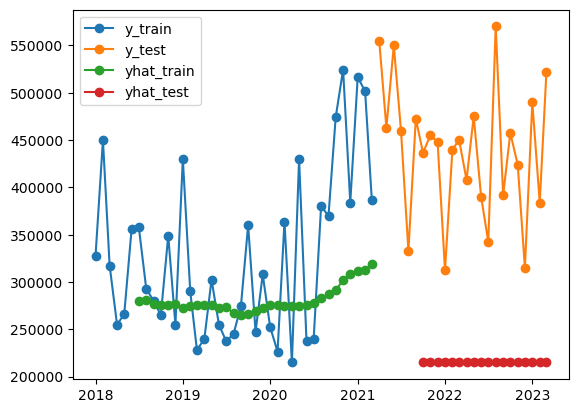

district_no 14 linear interpolation applied
Epoch 1/20


2023-04-05 22:38:38.545546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:39.975387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:41.278840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:42.329302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:44.220481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:45.686553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:38:47.194542: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 39s 723ms/step - loss: 0.0969
Epoch 2/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0844
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0816
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0833
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0845
Epoch 6/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0834
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0809
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0814
Epoch 9/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0811
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0808
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0821
Epoch 12/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0807
Epoch 13/20
33/33 [===========================

2023-04-05 22:39:40.399432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:39:41.417438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:39:42.424886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:39:43.493457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 20ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 65828.08 RMSE
Test Score: 200349.75 RMSE


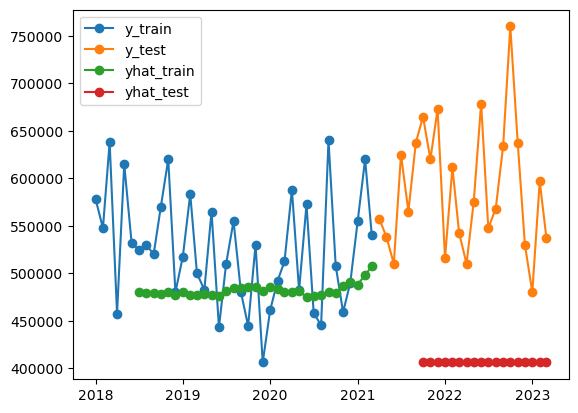

district_no 15 linear interpolation applied
Epoch 1/20


2023-04-05 22:40:00.386640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:40:01.859062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:40:03.103174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:40:04.337008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:40:06.261198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:40:07.691447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:40:09.741546: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 35s 618ms/step - loss: 0.1250
Epoch 2/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0997
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1018
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0980
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1000
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0988
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0989
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0981
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1002
Epoch 10/20
33/33 [==============================] - 2s 44ms/step - loss: 0.0987
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0978
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1010
Epoch 13/20
33/33 [===========================

2023-04-05 22:41:01.588819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:02.674345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:03.916346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:04.931218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 37ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 61495.02 RMSE
Test Score: 166301.78 RMSE


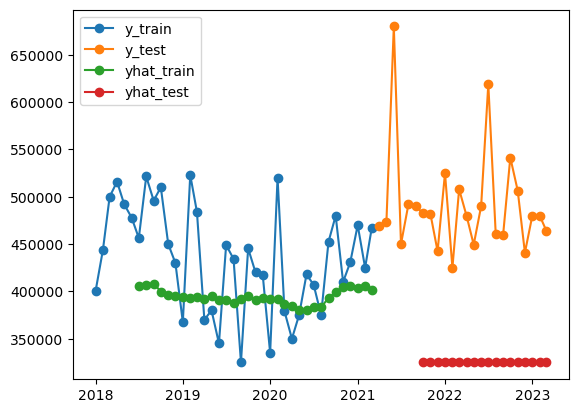

district_no 16 linear interpolation applied
Epoch 1/20


2023-04-05 22:41:20.759938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:22.379348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:23.365859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:24.640579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:26.446198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:28.174774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:41:30.794414: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 40s 671ms/step - loss: 0.0947
Epoch 2/20
33/33 [==============================] - 2s 48ms/step - loss: 0.0818
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0821
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0777
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0778
Epoch 6/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0788
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0801
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0786
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0751
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0752
Epoch 11/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0754
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0735
Epoch 13/20
33/33 [===========================

2023-04-05 22:42:23.763829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:42:24.569825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:42:25.774163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:42:26.802695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 31ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 21944.49 RMSE
Test Score: 122154.39 RMSE


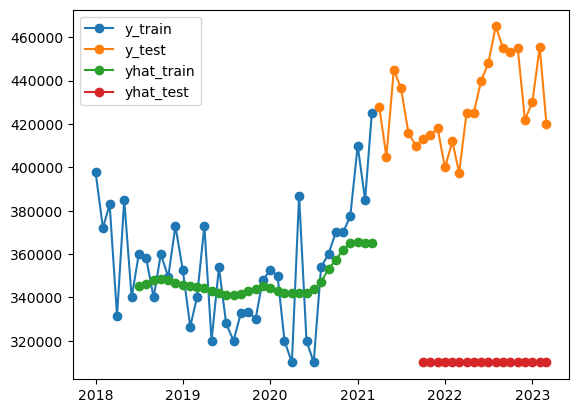

district_no 17 linear interpolation applied
Epoch 1/20


2023-04-05 22:42:48.397155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:42:50.480323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:42:52.490783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:42:54.394501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:42:58.799859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:43:00.964945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:43:02.771642: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 54s 948ms/step - loss: 0.0812
Epoch 2/20
33/33 [==============================] - 3s 86ms/step - loss: 0.0737
Epoch 3/20
33/33 [==============================] - 2s 54ms/step - loss: 0.0723
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0709
Epoch 5/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0704
Epoch 6/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0697
Epoch 7/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0698
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0700
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0696
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0694
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0693
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0695
Epoch 13/20
33/33 [===========================

2023-04-05 22:44:06.726129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:07.587117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:08.884161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:10.589353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 10s 615ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 63300.40 RMSE
Test Score: 186879.82 RMSE


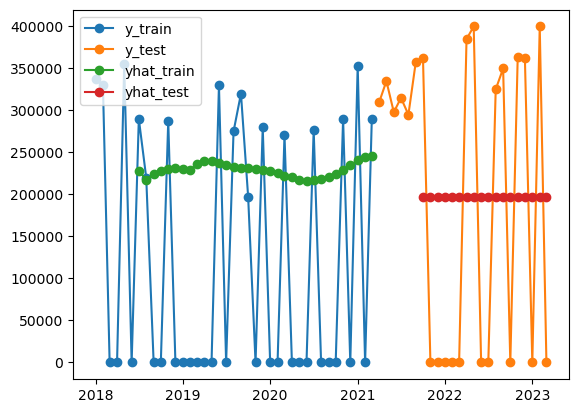

district_no 18 linear interpolation applied
Epoch 1/20


2023-04-05 22:44:39.669206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:41.195446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:42.783223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:44.267305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:46.443468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:48.035985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:44:49.811728: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 50s 971ms/step - loss: 0.1189
Epoch 2/20
33/33 [==============================] - 3s 85ms/step - loss: 0.1060
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1032
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1019
Epoch 5/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1028
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1036
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0993
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1013
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1000
Epoch 10/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0986
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0987
Epoch 12/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0983
Epoch 13/20
33/33 [===========================

2023-04-05 22:45:54.377604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:45:55.746027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:45:57.189294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:45:58.331618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 22ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 19484.83 RMSE
Test Score: 134166.01 RMSE


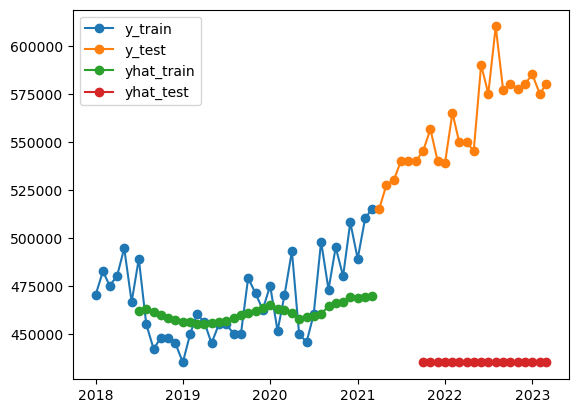

district_no 19 linear interpolation applied
Epoch 1/20


2023-04-05 22:46:19.557451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:46:21.118629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:46:22.590211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:46:24.363662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:46:26.253870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:46:28.104325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:46:29.792114: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 33s 411ms/step - loss: 0.1023
Epoch 2/20
33/33 [==============================] - 3s 80ms/step - loss: 0.0875
Epoch 3/20
33/33 [==============================] - 2s 56ms/step - loss: 0.0886
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0870
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0860
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0862
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0876
Epoch 8/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0858
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0862
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0857
Epoch 11/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0855
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0867
Epoch 13/20
33/33 [===========================

2023-04-05 22:47:16.160961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:17.307682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:18.222919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:19.215600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 21ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 13948.32 RMSE
Test Score: 127446.46 RMSE


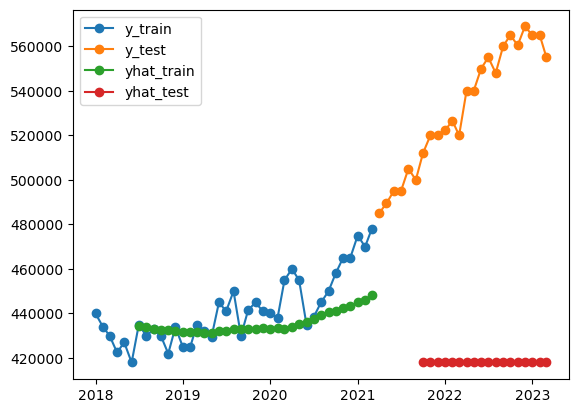

district_no 20 linear interpolation applied
Epoch 1/20


2023-04-05 22:47:31.754843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:33.368586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:34.509785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:35.700056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:37.397775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:38.718864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:47:40.070883: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 30s 454ms/step - loss: 0.1094
Epoch 2/20
33/33 [==============================] - 2s 61ms/step - loss: 0.0975
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1007
Epoch 4/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0959
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0964
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0952
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0962
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0973
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0955
Epoch 10/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0951
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0945
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0945
Epoch 13/20
33/33 [===========================

2023-04-05 22:48:25.407127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:26.496464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:27.441622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:28.438064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 22ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 43253.94 RMSE
Test Score: 180012.60 RMSE


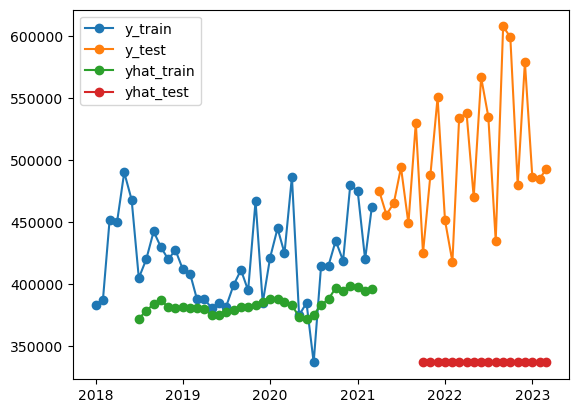

district_no 21 linear interpolation applied
Epoch 1/20


2023-04-05 22:48:43.040227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:44.634507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:46.053645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:47.232713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:49.005632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:50.501261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:48:51.910544: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 33s 585ms/step - loss: 0.1600
Epoch 2/20
33/33 [==============================] - 2s 53ms/step - loss: 0.1384
Epoch 3/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1378
Epoch 4/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1385
Epoch 5/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1380
Epoch 6/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1381
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1373
Epoch 8/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1384
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1381
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1372
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1381
Epoch 12/20
33/33 [==============================] - 1s 44ms/step - loss: 0.1384
Epoch 13/20
33/33 [===========================

2023-04-05 22:49:41.395046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:49:42.437311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:49:43.273490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:49:44.085750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 18ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 291490.93 RMSE
Test Score: 532719.12 RMSE


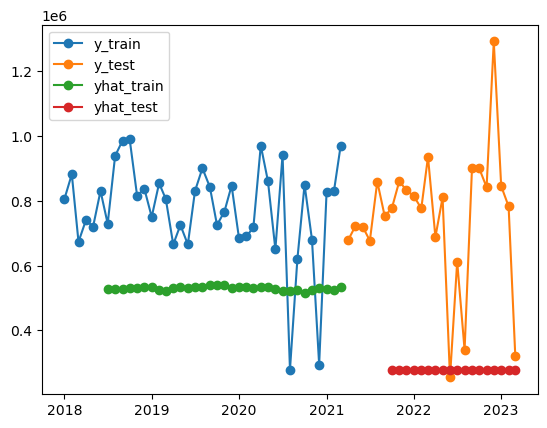

district_no 22 linear interpolation applied
Epoch 1/20


2023-04-05 22:50:00.490991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:50:02.143306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:50:03.436176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:50:04.686194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:50:06.779737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:50:08.568001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:50:10.444625: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 39s 715ms/step - loss: 0.1117
Epoch 2/20
33/33 [==============================] - 2s 65ms/step - loss: 0.0919
Epoch 3/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0915
Epoch 4/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0920
Epoch 5/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0925
Epoch 6/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0905
Epoch 7/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0895
Epoch 8/20
33/33 [==============================] - 2s 51ms/step - loss: 0.0898
Epoch 9/20
33/33 [==============================] - 2s 47ms/step - loss: 0.0909
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0897
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0909
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0891
Epoch 13/20
33/33 [===========================

2023-04-05 22:51:06.990878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:08.197356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:09.519616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:10.604724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 20ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 22725.24 RMSE
Test Score: 124156.83 RMSE


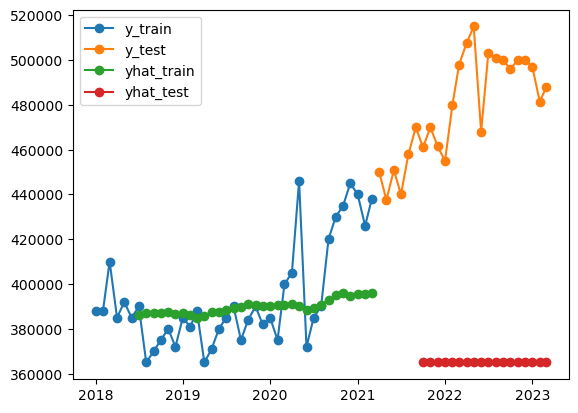

district_no 23 linear interpolation applied
Epoch 1/20


2023-04-05 22:51:26.720853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:28.550883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:30.004340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:31.361566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:33.239465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:34.892233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:51:36.543061: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 43s 839ms/step - loss: 0.1268
Epoch 2/20
33/33 [==============================] - 2s 66ms/step - loss: 0.1001
Epoch 3/20
33/33 [==============================] - 2s 46ms/step - loss: 0.1004
Epoch 4/20
33/33 [==============================] - 2s 47ms/step - loss: 0.1001
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0989
Epoch 6/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0978
Epoch 7/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0969
Epoch 8/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0991
Epoch 9/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0987
Epoch 10/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0978
Epoch 11/20
33/33 [==============================] - 1s 41ms/step - loss: 0.0967
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0965
Epoch 13/20
33/33 [===========================

2023-04-05 22:52:35.936721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:52:36.887070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:52:38.220438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:52:39.398212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 15ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 25361.51 RMSE
Test Score: 159013.19 RMSE


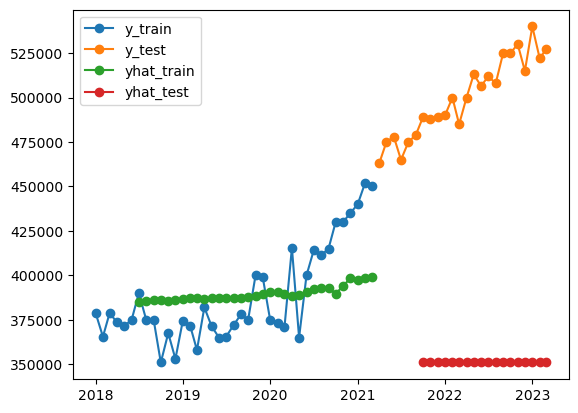

district_no 25 linear interpolation applied
Epoch 1/20


2023-04-05 22:52:59.965843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:53:01.869869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:53:03.636214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:53:04.983637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:53:07.251814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:53:09.190010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:53:11.063056: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 46s 830ms/step - loss: 0.1061
Epoch 2/20
33/33 [==============================] - 2s 64ms/step - loss: 0.0949
Epoch 3/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0944
Epoch 4/20
33/33 [==============================] - 2s 45ms/step - loss: 0.0954
Epoch 5/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0943
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0946
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0955
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0949
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.0940
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0949
Epoch 11/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0942
Epoch 12/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0941
Epoch 13/20
33/33 [===========================

2023-04-05 22:54:08.769330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:09.658401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:10.704358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:11.758486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 24443.40 RMSE
Test Score: 164809.10 RMSE


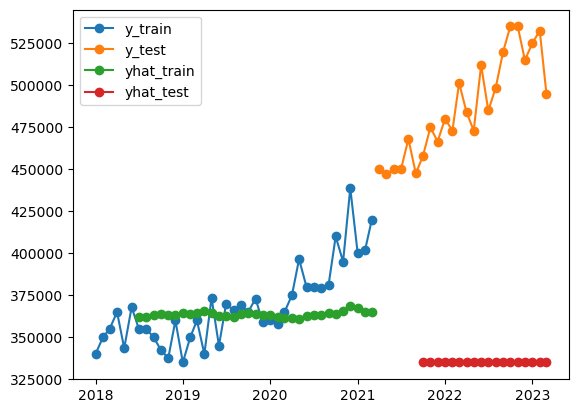

district_no 27 linear interpolation applied
Epoch 1/20


2023-04-05 22:54:30.492071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:32.231978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:33.419785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:34.877708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:36.919918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:38.796664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:54:40.775419: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 49s 962ms/step - loss: 0.1590
Epoch 2/20
33/33 [==============================] - 2s 49ms/step - loss: 0.1347
Epoch 3/20
33/33 [==============================] - 2s 48ms/step - loss: 0.1312
Epoch 4/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1305
Epoch 5/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1304
Epoch 6/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1300
Epoch 7/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1296
Epoch 8/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1295
Epoch 9/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1292
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.1303
Epoch 11/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1296
Epoch 12/20
33/33 [==============================] - 1s 43ms/step - loss: 0.1296
Epoch 13/20
33/33 [===========================

2023-04-05 22:55:42.073620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:55:42.911123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:55:43.712083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:55:44.702776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 25ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 22853.98 RMSE
Test Score: 146544.76 RMSE


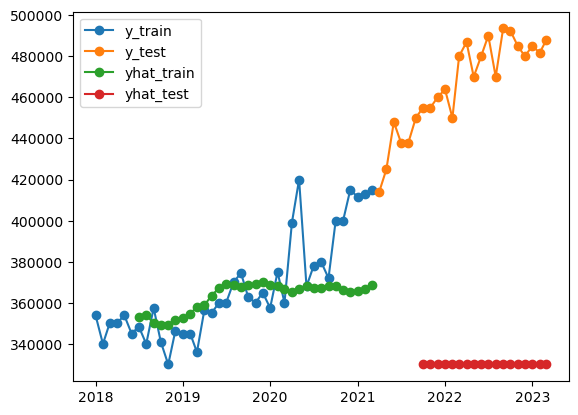

district_no 28 linear interpolation applied
Epoch 1/20


2023-04-05 22:56:02.417495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:56:04.070718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:56:05.424359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:56:07.111253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:56:09.291470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:56:11.050246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:56:12.737249: I tensorflow/core/grappler/optimizers/cust

33/33 [==============================] - 50s 965ms/step - loss: 0.1129
Epoch 2/20
33/33 [==============================] - 1s 45ms/step - loss: 0.1000
Epoch 3/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0970
Epoch 4/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0973
Epoch 5/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0962
Epoch 6/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0966
Epoch 7/20
33/33 [==============================] - 2s 59ms/step - loss: 0.0968
Epoch 8/20
33/33 [==============================] - 2s 46ms/step - loss: 0.0964
Epoch 9/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0960
Epoch 10/20
33/33 [==============================] - 1s 42ms/step - loss: 0.0943
Epoch 11/20
33/33 [==============================] - 1s 44ms/step - loss: 0.0941
Epoch 12/20
33/33 [==============================] - 1s 45ms/step - loss: 0.0939
Epoch 13/20
33/33 [===========================

2023-04-05 22:57:15.512575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:57:16.586693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:57:17.812439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-05 22:57:18.835481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 17ms/step
yhat train shape (33, 10)
yhat test shape (18, 10)
y train shape (33,)
y test shape (18,)
Train Score: 17434.84 RMSE
Test Score: 131064.18 RMSE


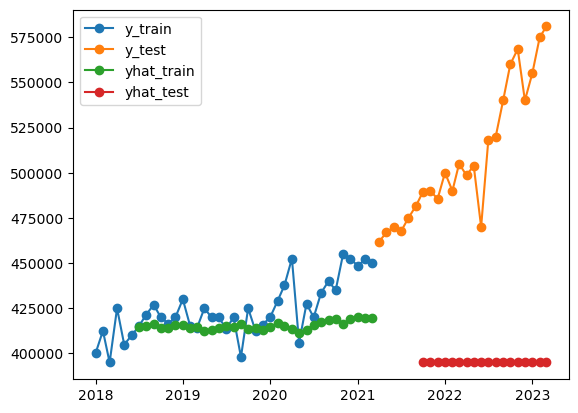

In [44]:
def fit_lstm_L(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model

def evaluate_lstm_L(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict_L[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict_L[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict_L[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    try:
        train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
        print('Train Score: %.2f RMSE' % (train_score))
        test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
        print('Test Score: %.2f RMSE' % (test_score))
    except ValueError:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except ValueError:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score

# run the model for all districts with linear interpolation applied to the missing values
district_no_list = list(train_lstm_df_dict_L.keys())
test_score_dict_LI = {}

for district_no in district_no_list:
    print("district_no", district_no, "linear interpolation applied")
    model = fit_lstm_L(train_lstm_dataset_dict_L[district_no])
    test_score = evaluate_lstm_L(
        model=model,
        X_train=train_lstm_dataset_dict_L[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict_LI[district_no] = test_score 

# Evaluation

In [55]:
evaluations_df = pd.read_csv("eval/SARIMA_SARIMAX_evaluations.csv", index_col=0)

evaluations_df["LSTM"] = pd.Series(test_score_dict)
evaluations_df["LSTM_LI"] = pd.Series(test_score_dict_LI)

# drop best model column
evaluations_df.drop(columns=["Best Model"], inplace=True)

def model_comparator(row):
    return row.index[row.values == row.min()].to_list()

evaluations_df["best_model"] = evaluations_df.apply(model_comparator, axis=1)
evaluations_df['best_model'] = evaluations_df['best_model'].apply(lambda x: ["RMSE_Baseline"] if "RMSE_Baseline" in x else x)


# Poor performance of LSTM

In [56]:
evaluations_df


,RMSE_SARIMAX,RMSE_SARIMAX_L,RMSE_SARIMA,RMSE_SARIMA_L,RMSE_Baseline,LSTM,LSTM_LI,best_model
1,1.725116e+05,8.092334e+04,8.092334e+04,8.092334e+04,80923.339144,452249.188317,149832.667778,[RMSE_Baseline]
2,1.653056e+05,1.698050e+05,1.653056e+05,1.698050e+05,87935.362860,942151.447461,481880.597194,[RMSE_Baseline]
3,3.882617e+04,3.882617e+04,3.882617e+04,3.882617e+04,38424.434301,187180.716545,187180.716545,[RMSE_Baseline]
4,1.126580e+05,1.126580e+05,1.126580e+05,1.126580e+05,103630.484743,270948.225586,270948.225586,[RMSE_Baseline]
5,7.284013e+04,7.284013e+04,7.284013e+04,7.284013e+04,72840.126460,244527.719401,244527.719401,[RMSE_Baseline]
7,1.151819e+05,1.172143e+05,1.151819e+05,1.172143e+05,94444.824771,478284.915731,188147.553663,[RMSE_Baseline]
8,7.766312e+04,7.320619e+04,7.766312e+04,7.320619e+04,68113.848543,572042.354448,187852.819913,[RMSE_Baseline]
10,7.981001e+05,7.981001e+05,7.981001e+05,7.981001e+05,151364.913684,275993.260684,275993.260684,[RMSE_Baseline]
12,1.145391e+05,1.145391e+05,1.145391e+05,1.145391e+05,125802.904235,346430.901811,346430.901811,"[RMSE_SARIMAX, RMSE_SARIMAX_L, RMSE_SARIMA, RM..."
13,6.995903e+04,6.995903e+04,6.995903e+04,6.995903e+04,87425.768337,223126.427789,223126.427789,"[RMSE_SARIMAX, RMSE_SARIMAX_L, RMSE_SARIMA, RM..."


In [57]:
evaluations_df.to_csv("eval/SARIMA_SARIMAX_LSTM_evaluations.csv")

In [58]:
evaluations_df['best_model'].value_counts()

[RMSE_Baseline]                                               20
[RMSE_SARIMAX, RMSE_SARIMAX_L, RMSE_SARIMA, RMSE_SARIMA_L]     3
Name: best_model, dtype: int64